In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///C:\\Users\\Ben Huang\\Desktop\\SQLAlchemyHW\\hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
query = session.query(Measurement.date, func.sum(Measurement.prcp)).group_by(Measurement.date).\
    order_by(Measurement.id.desc()).limit(365).all()


![precipitation](Images/precipitation.png)

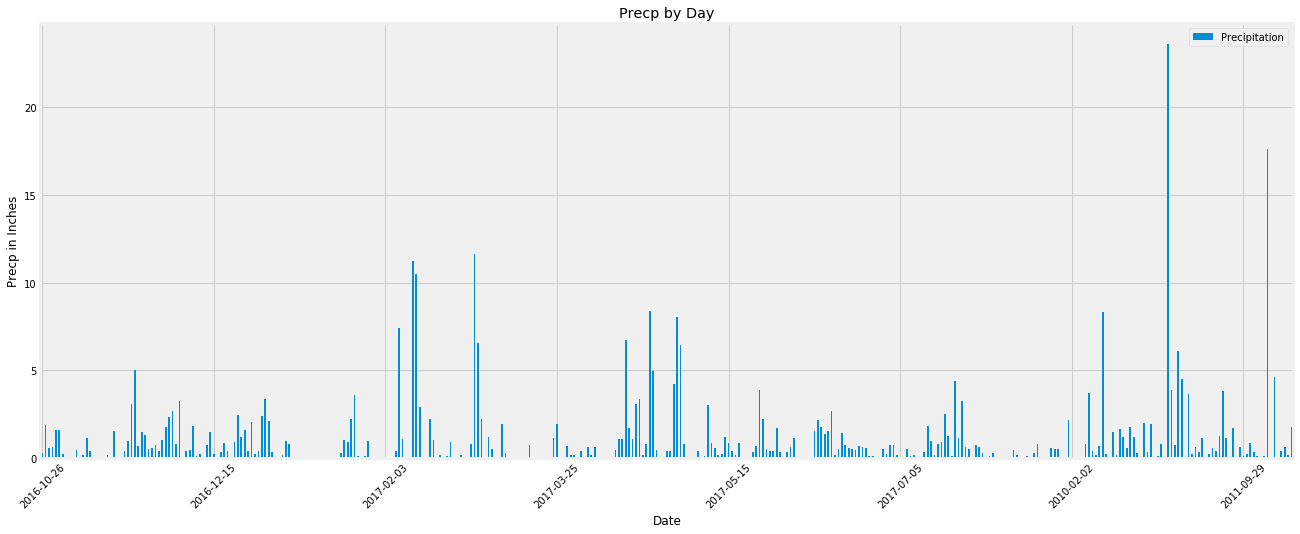

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation = pd.DataFrame(query,columns=['Date','Precipitation'])
precipitation = precipitation.sort_index(ascending=False)
precipitation = precipitation.reset_index()
precipitation = precipitation.drop('index',1)
precipitation.head()

dd = np.arange(0,400,50)
dd = dd.tolist()
dd

date_dd = []
for x in dd:
    date = precipitation['Date'][x]
    date_dd.append(date)
date_dd
precipitation = precipitation.set_index('Date')
precipitation.plot(kind='bar',figsize=(20,8))
plt.xticks(dd,date_dd,rotation=45)
plt.title('Precp by Day')
plt.ylabel('Precp in Inches')
plt.show()

![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
NumberofStations = session.query(func.count(Station.id)).all()
NumberofStations

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
ActiveStations = session.query(Station.station,Station.name,func.count(Measurement.date)). \
    filter(Station.station==Measurement.station).\
    group_by(Station.name).order_by(func.count(Measurement.date).desc()).all()
ActiveStations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
highest_temp = 'USC00519281'
high = session.query(Measurement.date,Measurement.tobs).order_by(Measurement.id.desc()). \
    filter(Measurement.station==highest_temp).limit(365).all()
high

[('2017-08-18', 79.0),
 ('2017-08-17', 76.0),
 ('2017-08-16', 76.0),
 ('2017-08-15', 77.0),
 ('2017-08-14', 77.0),
 ('2017-08-13', 77.0),
 ('2017-08-06', 83.0),
 ('2017-08-05', 82.0),
 ('2017-08-04', 77.0),
 ('2017-07-31', 76.0),
 ('2017-07-30', 81.0),
 ('2017-07-29', 82.0),
 ('2017-07-28', 81.0),
 ('2017-07-27', 76.0),
 ('2017-07-26', 75.0),
 ('2017-07-25', 77.0),
 ('2017-07-24', 75.0),
 ('2017-07-23', 82.0),
 ('2017-07-22', 77.0),
 ('2017-07-21', 77.0),
 ('2017-07-20', 77.0),
 ('2017-07-19', 76.0),
 ('2017-07-18', 76.0),
 ('2017-07-17', 76.0),
 ('2017-07-16', 80.0),
 ('2017-07-15', 80.0),
 ('2017-07-14', 76.0),
 ('2017-07-13', 74.0),
 ('2017-07-12', 74.0),
 ('2017-07-11', 72.0),
 ('2017-07-10', 69.0),
 ('2017-07-09', 78.0),
 ('2017-07-08', 78.0),
 ('2017-07-07', 75.0),
 ('2017-07-06', 74.0),
 ('2017-07-05', 77.0),
 ('2017-07-04', 78.0),
 ('2017-07-03', 76.0),
 ('2017-07-02', 81.0),
 ('2017-07-01', 79.0),
 ('2017-06-30', 76.0),
 ('2017-06-29', 76.0),
 ('2017-06-28', 77.0),
 ('2017-06-

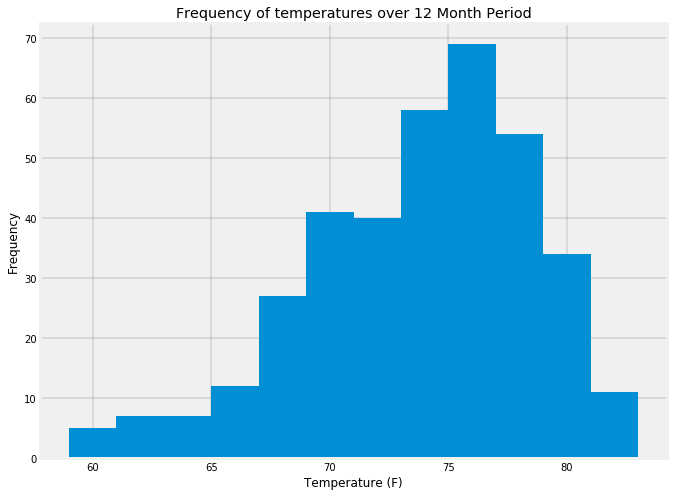

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = pd.DataFrame(high,columns=['Date','Temp Obs'])
tobs.head()
plt.figure(figsize=(10,8))
plt.hist(tobs["Temp Obs"], bins=12)
plt.grid(color='grey', linestyle='-', linewidth=2, alpha=.2)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.title("Frequency of temperatures over 12 Month Period")
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps= calc_temps('2017-02-28', '2017-03-05')

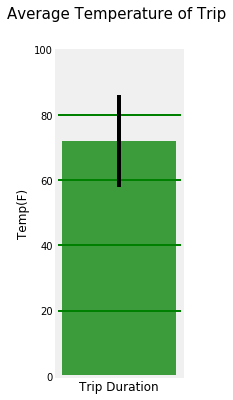

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
date1=dt.date(2017,2,28)
date2=dt.date(2017,3,5)
trip = date2-date1
rg = pd.date_range('2017-02-28', '2017-03-05',periods=5, normalize=True)
trip_temps[0][1]
trip_dictionary = {'tmin':trip_temps[0][0],'tavg':trip_temps[0][1],'tmax':trip_temps[0][2]}
yerr=trip_dictionary['tmax'] - trip_dictionary['tmin']
plt.figure(figsize=(2,6))
plt.bar(1,trip_dictionary['tavg'],yerr=yerr,align='center',color='green', alpha= .75)
plt.xticks([])
plt.ylim(0,100)
plt.ylabel("Temp(F)")
plt.xlabel("Trip Duration")
plt.grid(color='g', linestyle='-', linewidth=2,)
plt.suptitle("Average Temperature of Trip", size = 15)
plt.show()

In [19]:
from flask import Flask, jsonify
app = Flask(__name__)


In [20]:

@app.route("/")
def welcome1():

    return(
        f"Available Routes: <br/>"
        f"/api/v1.0/precipitation <br/>"
        f"/api/v1.0/stations <br/>"
        f"/api/v1.0/tobs <br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

In [ ]:
@app.route("/api/v1.0/precipitation")
def precipitation():
 
    
    prcp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > '2017-01-01').all()
    

    all_prcp = []
    for prcp in prcp_results:
        prcp_dict = {}
        prcp_dict["Date"] = Measurement.date
        prcp_dict["TOBS"] = Measurement.tobs
        all_prcp.append(prcp_dict)
    return jsonify(all_prcp)

In [ ]:
@app.route("/api/v1.0/stations")
def stations():

    
    station_results = session.query(Station.station).all()
    
    all_stations = list(np.ravel(station_results))
    
    return jsonify(all_stations)

In [ ]:

@app.route("/api/v1.0/tobs")
def tobs():
    tobs_results = session.query(Measurement.tobs).filter(Measurement.date > '2017-01-01').all()

    all_tobs = list(np.ravel(tobs_results))
    
    return jsonify(all_tobs)

In [ ]:

if __name__ == '__main__':
    app.run(debug=True)

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
